# Ollama Phi-3.5 Integration

In [65]:
!pip install -q httpx pandas matplotlib seaborn tabulate requests python-dotenv


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [66]:
import httpx
import json
import time
import requests
from typing import Dict, List, Tuple
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Config
OLLAMA_URL = "http://localhost:11434"
OLLAMA_MODEL = "phi3.5:latest"
API_URL = "http://localhost:8000"

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Health Check de Servicios

In [67]:
def test_ollama_health():
    """Validate ollama is running and the model is available."""
    try:
        with httpx.Client(timeout=5.0) as client:
            response = client.get(f"{OLLAMA_URL}/api/tags")
            if response.status_code == 200:
                models = response.json().get('models', [])
                model_names = [m['name'] for m in models]
                
                print("Ollama is running")
                print(f"   Available models: {len(models)}")
                
                if OLLAMA_MODEL in model_names:
                    print(f"   Model {OLLAMA_MODEL} found")
                    return True
                else:
                    print(f"   Model {OLLAMA_MODEL} NOT found")
                    print(f"   Available: {', '.join(model_names[:3])}")
                    return False
            else:
                print(f"Ollama responded with status code {response.status_code}")
                return False
    except Exception as e:
        print(f"Error connecting to Ollama: {e}")
        return False

def test_api_health():
    """Verify that the AquaIA API is running."""
    try:
        response = requests.get(f"{API_URL}/embalses", timeout=5)
        if response.status_code == 200:
            embalses = response.json()
            print("AquaIA API is running")
            print(f"   Available embalses: {len(embalses)}")
            return True, embalses
        else:
            print(f" API responded with status code {response.status_code}")
            return False, []
    except Exception as e:
        print(f" Error connecting to the API: {e}")
        return False, []

# Run health checks
print("=" * 60)
print("HEALTH CHECKS")
print("=" * 60)

ollama_ok = test_ollama_health()
print()
api_ok, embalses = test_api_health()

print()
if ollama_ok and api_ok:
    print("All services are operational")
else:
    print("Some services are not available")

HEALTH CHECKS
Ollama is running
   Available models: 2
   Model phi3.5:latest found

AquaIA API is running
   Available embalses: 30

All services are operational


## Test 2: Direct Generation with Ollama

Tests recommendation generation directly with Ollama without using the API.

In [68]:
def generate_recommendation_ollama(scenario: Dict) -> Tuple[Dict, float]:
    """
    Generate recommendation using Ollama directly.
    
    Args:
        scenario: Dictionary with scenario data
        
    Returns:
        (response_dict, elapsed_time_ms)
    """
    prompt = f"""Eres un ingeniero hidráulico experto especializado en gestión de embalses. Analiza los siguientes datos del embalse:

EMBALSE: {scenario['nombre']}
NIVEL ACTUAL: {scenario['nivel_actual']:.2f} hm³
CAPACIDAD MÁXIMA: {scenario['capacidad_maxima']} hm³
PREDICCIÓN ({scenario['horizonte']} días): {scenario['nivel_predicho']:.2f} hm³ ({scenario['porcentaje']:.1f}% capacidad)
NIVEL DE RIESGO: {scenario['riesgo']}
TENDENCIA: {scenario['tendencia']}

Proporciona un análisis técnico en formato JSON con exactamente estos campos:
- "reasoning": Explicación técnica concisa de la situación de riesgo (2-3 frases enfocadas en las implicaciones hidrológicas)
- "recommended_action": Acciones operativas específicas a tomar (sé concreto y accionable)

Devuelve únicamente JSON válido sin texto adicional ni explicaciones."""

    start_time = time.time()
    
    try:
        with httpx.Client(timeout=60.0) as client:
            response = client.post(
                f"{OLLAMA_URL}/api/generate",
                json={
                    "model": OLLAMA_MODEL,
                    "prompt": prompt,
                    "stream": False,
                    "format": "json",
                    "options": {
                        "temperature": 0.7,
                        "top_p": 0.9
                    }
                }
            )
            response.raise_for_status()
            result = response.json()
            
            elapsed_ms = (time.time() - start_time) * 1000
            
            response_text = result.get('response', '{}')
            data = json.loads(response_text)
            
            # Normalize reasoning and action to strings
            reasoning = data.get('reasoning', data.get('motivo', ''))
            action = data.get('recommended_action', data.get('accion', ''))
            
            # Convert lists to strings if necessary
            if isinstance(reasoning, list):
                reasoning = ' '.join(str(item) for item in reasoning)
            if isinstance(action, list):
                action = ' '.join(str(item) for item in action)
            
            return {
                'reasoning': str(reasoning) if reasoning else '',
                'recommended_action': str(action) if action else '',
                'tokens': result.get('eval_count', 0),
                'total_time_ms': elapsed_ms,
                'model': result.get('model', OLLAMA_MODEL)
            }, elapsed_ms
            
    except Exception as e:
        return {'error': str(e)}, -1

# Escenarios de prueba
test_scenarios = [
    {
        'nombre': 'Embalse de Prueba - Riesgo Alto',
        'nivel_actual': 250.0,
        'capacidad_maxima': 400.0,
        'nivel_predicho': 385.0,
        'porcentaje': 96.25,
        'horizonte': 90,
        'riesgo': 'ALTO',
        'tendencia': 'CRECIENTE'
    },
    {
        'nombre': 'Embalse de Prueba - Riesgo Moderado',
        'nivel_actual': 300.0,
        'capacidad_maxima': 400.0,
        'nivel_predicho': 340.0,
        'porcentaje': 85.0,
        'horizonte': 90,
        'riesgo': 'MODERADO',
        'tendencia': 'ESTABLE'
    },
    {
        'nombre': 'Embalse de Prueba - Sequía',
        'nivel_actual': 150.0,
        'capacidad_maxima': 400.0,
        'nivel_predicho': 80.0,
        'porcentaje': 20.0,
        'horizonte': 90,
        'riesgo': 'SEQUIA',
        'tendencia': 'DECRECIENTE'
    }
]

print("=" * 60)
print("DIRECT GENERATION WITH OLLAMA")
print("=" * 60)

results = []

for i, scenario in enumerate(test_scenarios, 1):
    print(f"\nTest {i}/{len(test_scenarios)}: {scenario['nombre']}")
    print(f"   Risk: {scenario['riesgo']} | Level: {scenario['porcentaje']:.1f}%")
    
    result, elapsed_time = generate_recommendation_ollama(scenario)
    
    if 'error' in result:
        print(f"   [ERROR] {result['error']}")
    else:
        print(f"   [OK] Generated in {elapsed_time:.0f}ms ({result.get('tokens', 0)} tokens)")
        reasoning = result.get('reasoning', '')
        action = result.get('recommended_action', '')
        print(f"   Reasoning: {reasoning[:100] if reasoning else 'N/A'}...")
        print(f"   Action: {action[:100] if action else 'N/A'}...")
        
        results.append({
            'Scenario': scenario['riesgo'],
            'Chars Reasoning': len(result.get('reasoning', '')),
            'Chars Action': len(result.get('recommended_action', '')),
        })

if results:
    print("\n" + "=" * 60)
    print("PERFORMANCE SUMMARY")
    print("=" * 60)

    df_results = pd.DataFrame(results)    
    print(tabulate(df_results, headers='keys', tablefmt='grid', showindex=False))

DIRECT GENERATION WITH OLLAMA

Test 1/3: Embalse de Prueba - Riesgo Alto
   Risk: ALTO | Level: 96.2%


   [OK] Generated in 26465ms (201 tokens)
   Reasoning: El nivel actual del embalse está muy cerca de la capacidad máxima, indicando una alta probabilidad d...
   Action: Reducir el ingreso de agua al embalse a un nivel seguro para mantener una ventana operativa que perm...

Test 2/3: Embalse de Prueba - Riesgo Moderado
   Risk: MODERADO | Level: 85.0%
   [OK] Generated in 19599ms (220 tokens)
   Reasoning: El embalse está alrededor de un 85% del nivel máximo, lo que indica una capacidad constante y posibl...
   Action: Monitorear continuamente el nivel del embalse y preparar un protocolo operativo para liberación grad...

Test 3/3: Embalse de Prueba - Sequía
   Risk: SEQUIA | Level: 20.0%
   [OK] Generated in 20983ms (242 tokens)
   Reasoning: El embalse de Prueba se encuentra actualmente al 37,5% de su capacidad máxima con un nivel real de s...
   Action: Iniciar campaña urgente de conservación del agua a nivel comunitario y aumento en el monitoreo frecu...

PERFORMANCE SUMMARY
+----

## Test 3: API Integration

Tests recommendation generation through the complete API with real reservoir data.

In [69]:
def test_api_recommendation(codigo_saih: str, forzar: bool = True) -> Dict:
    """
    Request a recommendation through the API.
    
    Args:
        codigo_saih: Reservoir SAIH code
        forzar: If True, forces regeneration
        
    Returns:
        Dictionary with the response
    """
    try:
        url = f"{API_URL}/recomendaciones/{codigo_saih}"
        params = {
            'forzar_regeneracion': 'true' if forzar else 'false',
            'horizonte_dias': 90
        }
        
        start_time = time.time()
        response = requests.get(url, params=params, timeout=120)
        elapsed_ms = (time.time() - start_time) * 1000
        
        if response.status_code == 200:
            data = response.json()
            return {
                'success': True,
                'data': data,
                'elapsed_ms': elapsed_ms
            }
        else:
            return {
                'success': False,
                'error': f"Status {response.status_code}",
                'elapsed_ms': elapsed_ms
            }
    except Exception as e:
        return {
            'success': False,
            'error': str(e),
            'elapsed_ms': -1
        }

# Get list of available reservoirs
if api_ok and len(embalses) > 0:
    print("=" * 60)
    print("API INTEGRATION - REAL RESERVOIRS")
    print("=" * 60)
    
    # Take first 3 reservoirs as sample
    sample_embalses = embalses[:3]
    
    api_results = []
    
    for embalse in sample_embalses:
        code = embalse.get('codigo_saih', 'N/A')
        name = embalse.get('ubicacion', 'Unknown')
        
        print(f"\nReservoir: {name} ({code})")
        
        result = test_api_recommendation(code, forzar=True)
        
        if result['success']:
            data = result['data']
            print(f"   [OK] Recommendation generated in {result['elapsed_ms']:.0f}ms")
            print(f"   Risk Level: {data.get('nivel_riesgo', 'N/A')}")
            print(f"   Current Level: {data.get('nivel_actual', 0):.2f} hm³")
            print(f"   Forecast Level: {data.get('nivel_predicho_medio', 0):.2f} hm³")
            print(f"   Reasoning: {data.get('motivo', '')[:120]}...")
            print(f"   Action: {data.get('accion_recomendada', '')[:120]}...")
            
            api_results.append({
                'Code': code,
                'Reservoir': name[:30],
                'Risk': data.get('nivel_riesgo', 'N/A'),
                'Level (%)': f"{(data.get('nivel_actual', 0) / data.get('nivel_maximo', 1) * 100):.1f}",
                'Time (ms)': f"{result['elapsed_ms']:.0f}"
            })
        else:
            print(f"   [ERROR] {result['error']}")
    
    if api_results:
        print("\n" + "=" * 60)
        print("API TEST SUMMARY")
        print("=" * 60)
        df_api = pd.DataFrame(api_results)
        print(tabulate(df_api, headers='keys', tablefmt='grid', showindex=False))
else:
    print("[WARNING] API not available or no reservoirs. Skipping integration tests.")

API INTEGRATION - REAL RESERVOIRS

Reservoir: Belesar (E001)
   [OK] Recommendation generated in 121ms
   Risk Level: MODERADO
   Current Level: 317.65 hm³
   Forecast Level: 293.23 hm³
   Reasoning: El nivel predicho se situará en 88.9% de capacidad (293.23 hm³) dentro de 90 días. Tendencia: bajando. Incertidumbre: ±0...
   Action: Incrementar frecuencia de monitoreo. Evaluar desembalses graduales. Revisar pronósticos meteorológicos....

Reservoir: Os Peares (E002)
   [OK] Recommendation generated in 71ms
   Risk Level: ALTO
   Current Level: 193.45 hm³
   Forecast Level: 186.03 hm³
   Reasoning: El nivel predicho alcanzará 95.8% de la capacidad máxima (194.20 hm³) en los próximos 90 días, con nivel esperado de 186...
   Action: URGENTE: Planificar desembalses preventivos. Coordinar con organismos de cuenca. Activar protocolos de emergencia y sist...

Reservoir: As Rozas (E003)
   [OK] Recommendation generated in 77ms
   Risk Level: ALTO
   Current Level: 945.06 hm³
   Forecast Level:

## Test 4: Performance Analysis

Detailed metrics for latency and model throughput.

PERFORMANCE BENCHMARK
Running 5 iterations for benchmark...
   Iteration 1/5: 17875ms
   Iteration 2/5: 14035ms
   Iteration 3/5: 15116ms
   Iteration 4/5: 12965ms
   Iteration 5/5: 17050ms

Latency Statistics:
   Mean: 15408ms
   Median: 15116ms
   Std Dev: 2045ms
   Min: 12965ms
   Max: 17875ms

Token Statistics:
   Mean: 231 tokens
   Throughput: 15.0 tokens/s


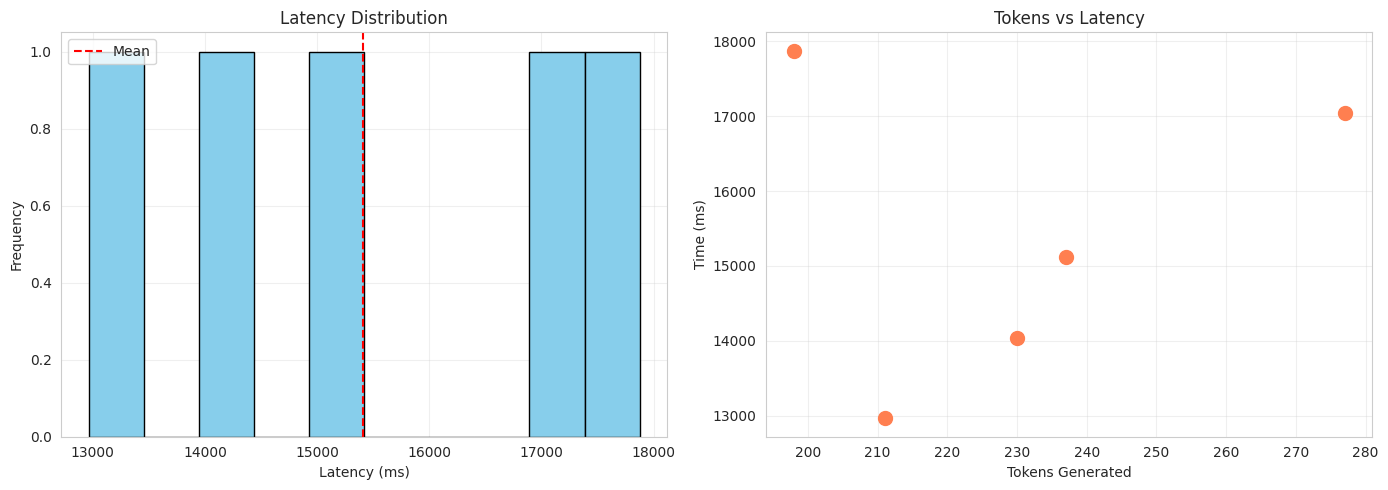

In [70]:
def benchmark_ollama(n_iterations: int = 5) -> pd.DataFrame:
    """
    Execute multiple iterations to measure statistical performance.
    
    Args:
        n_iterations: Number of iterations per scenario
        
    Returns:
        DataFrame with metrics
    """
    benchmark_scenario = {
        'nombre': 'Benchmark',
        'nivel_actual': 300.0,
        'capacidad_maxima': 400.0,
        'nivel_predicho': 350.0,
        'porcentaje': 87.5,
        'horizonte': 90,
        'riesgo': 'MODERADO',
        'tendencia': 'ESTABLE'
    }
    
    times = []
    tokens_list = []
    
    print(f"Running {n_iterations} iterations for benchmark...")
    
    for i in range(n_iterations):
        result, elapsed = generate_recommendation_ollama(benchmark_scenario)
        if 'error' not in result:
            times.append(elapsed)
            tokens_list.append(result.get('tokens', 0))
            print(f"   Iteration {i+1}/{n_iterations}: {elapsed:.0f}ms")
    
    if times:
        return pd.DataFrame({
            'Time (ms)': times,
            'Tokens': tokens_list
        })
    return pd.DataFrame()

# Execute benchmark
print("=" * 60)
print("PERFORMANCE BENCHMARK")
print("=" * 60)

df_benchmark = benchmark_ollama(n_iterations=5)

if not df_benchmark.empty:
    print("\nLatency Statistics:")
    print(f"   Mean: {df_benchmark['Time (ms)'].mean():.0f}ms")
    print(f"   Median: {df_benchmark['Time (ms)'].median():.0f}ms")
    print(f"   Std Dev: {df_benchmark['Time (ms)'].std():.0f}ms")
    print(f"   Min: {df_benchmark['Time (ms)'].min():.0f}ms")
    print(f"   Max: {df_benchmark['Time (ms)'].max():.0f}ms")
    
    print("\nToken Statistics:")
    print(f"   Mean: {df_benchmark['Tokens'].mean():.0f} tokens")
    print(f"   Throughput: {(df_benchmark['Tokens'].mean() / (df_benchmark['Time (ms)'].mean() / 1000)):.1f} tokens/s")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Latency histogram
    axes[0].hist(df_benchmark['Time (ms)'], bins=10, color='skyblue', edgecolor='black')
    axes[0].axvline(df_benchmark['Time (ms)'].mean(), color='red', linestyle='--', label='Mean')
    axes[0].set_xlabel('Latency (ms)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Latency Distribution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Scatter plot time vs tokens
    axes[1].scatter(df_benchmark['Tokens'], df_benchmark['Time (ms)'], color='coral', s=100)
    axes[1].set_xlabel('Tokens Generated')
    axes[1].set_ylabel('Time (ms)')
    axes[1].set_title('Tokens vs Latency')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("[ERROR] Could not complete benchmark")

## Test 5: Response Quality Analysis

Evaluates quality, length, and coherence of generated responses.

RESPONSE QUALITY ANALYSIS

Scenario: ALTO
   Reasoning Length: 57 words (377 chars)
   Action Length: 40 words (281 chars)
   Technical Terms: Reasoning=4, Action=2
   Technical Score: 3.0/10

Scenario: MODERADO
   Reasoning Length: 56 words (349 chars)
   Action Length: 43 words (314 chars)
   Technical Terms: Reasoning=4, Action=1
   Technical Score: 2.5/10

Scenario: SEQUIA
   Reasoning Length: 61 words (364 chars)
   Action Length: 32 words (222 chars)
   Technical Terms: Reasoning=4, Action=1
   Technical Score: 2.5/10

QUALITY TABLE
+------------+-------------------+----------------+-----------------------+--------------------+-------------------+
| Scenario   |   Words Reasoning |   Words Action |   Sentences Reasoning |   Sentences Action |   Technical Score |
+============+===================+================+=======================+====================+===================+
| ALTO       |                57 |             40 |                     3 |                  2 |        

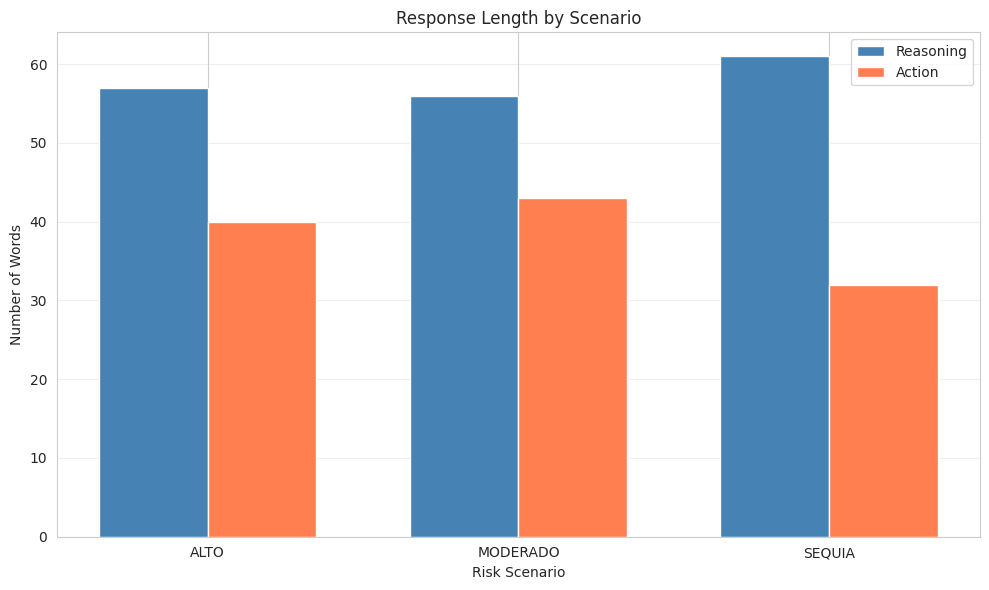

In [71]:
def analyze_response_quality(response: Dict) -> Dict:
    """
    Analyze quality metrics of a response.
    
    Args:
        response: Dictionary with 'reasoning' and 'recommended_action'
        
    Returns:
        Quality metrics dictionary
    """
    reasoning = response.get('reasoning', response.get('motivo', ''))
    action = response.get('recommended_action', response.get('accion', ''))
    
    # Convert to string if list
    if isinstance(reasoning, list):
        reasoning = ' '.join(str(item) for item in reasoning)
    if isinstance(action, list):
        action = ' '.join(str(item) for item in action)
    
    # Ensure they are strings
    reasoning = str(reasoning) if reasoning else ''
    action = str(action) if action else ''
    
    # Relevant technical keywords
    technical_keywords = [
        'reservoir', 'level', 'capacity', 'forecast', 'risk', 
        'discharge', 'flow', 'monitoring', 'threshold', 'protocol',
        'hm³', 'water', 'hydraulic', 'operational', 'preventive',
        'embalse', 'nivel', 'capacidad', 'predicho', 'riesgo'
    ]
    
    reasoning_lower = reasoning.lower()
    action_lower = action.lower()
    
    technical_reasoning = sum(1 for word in technical_keywords if word in reasoning_lower)
    technical_action = sum(1 for word in technical_keywords if word in action_lower)
    
    return {
        'chars_reasoning': len(reasoning),
        'chars_action': len(action),
        'words_reasoning': len(reasoning.split()),
        'words_action': len(action.split()),
        'sentences_reasoning': reasoning.count('.') + 1,
        'sentences_action': action.count('.') + 1,
        'technical_reasoning': technical_reasoning,
        'technical_action': technical_action,
        'technical_score': (technical_reasoning + technical_action) / 2
    }

# Analyze quality of previous scenarios
if results:
    print("=" * 60)
    print("RESPONSE QUALITY ANALYSIS")
    print("=" * 60)
    
    quality_data = []
    
    for i, scenario in enumerate(test_scenarios):
        print(f"\nScenario: {scenario['riesgo']}")
        
        result, _ = generate_recommendation_ollama(scenario)
        
        if 'error' not in result:
            metrics = analyze_response_quality(result)
            
            print(f"   Reasoning Length: {metrics['words_reasoning']} words ({metrics['chars_reasoning']} chars)")
            print(f"   Action Length: {metrics['words_action']} words ({metrics['chars_action']} chars)")
            print(f"   Technical Terms: Reasoning={metrics['technical_reasoning']}, Action={metrics['technical_action']}")
            print(f"   Technical Score: {metrics['technical_score']:.1f}/10")
            
            quality_data.append({
                'Scenario': scenario['riesgo'],
                'Words Reasoning': metrics['words_reasoning'],
                'Words Action': metrics['words_action'],
                'Sentences Reasoning': metrics['sentences_reasoning'],
                'Sentences Action': metrics['sentences_action'],
                'Technical Score': f"{metrics['technical_score']:.1f}"
            })
    
    if quality_data:
        print("\n" + "=" * 60)
        print("QUALITY TABLE")
        print("=" * 60)
        df_quality = pd.DataFrame(quality_data)
        print(tabulate(df_quality, headers='keys', tablefmt='grid', showindex=False))
        
        # Visualization
        fig, ax = plt.subplots(figsize=(10, 6))
        
        x = range(len(quality_data))
        reasoning_words = [d['Words Reasoning'] for d in quality_data]
        action_words = [d['Words Action'] for d in quality_data]
        
        width = 0.35
        ax.bar([i - width/2 for i in x], reasoning_words, width, label='Reasoning', color='steelblue')
        ax.bar([i + width/2 for i in x], action_words, width, label='Action', color='coral')
        
        ax.set_xlabel('Risk Scenario')
        ax.set_ylabel('Number of Words')
        ax.set_title('Response Length by Scenario')
        ax.set_xticks(x)
        ax.set_xticklabels([d['Scenario'] for d in quality_data])
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()

## Test 6: LLM vs Template Comparison

Compares LLM responses with predefined templates to evaluate added value.

COMPARISON: LLM vs BASIC TEMPLATES

Scenario: ALTO (96.2%)

   [LLM] (17431ms):
      Reasoning: El nivel actual del embalse está muy cerca de su capacidad máxima, lo que indica un alto riesgo potencial para inundaciones o fallos estructurales si ...
      Action: Reducir liberaciones deliberadamente para disminuir rápidamente los niveles de agua por debajo del umbral crítico; revisar e inspeccionar estructuras ...

   [Template]:
      Reasoning: Forecast level will reach 96.2% of maximum capacity (400.00 hm³) in the next 90 days, with expected level of 385.00 hm³....
      Action: URGENT: Plan preventive discharges. Coordinate with basin authorities. Activate emergency protocols and alert systems....

Scenario: MODERADO (85.0%)

   [LLM] (20685ms):
      Reasoning: El embalse está actualmente al 75% de su capacidad máxima, lo que indica una gestión prudente del agua con un margen considerable antes de alcanzar el...
      Action: Monitoree el embalse y ajuste la tasa de flujo según s

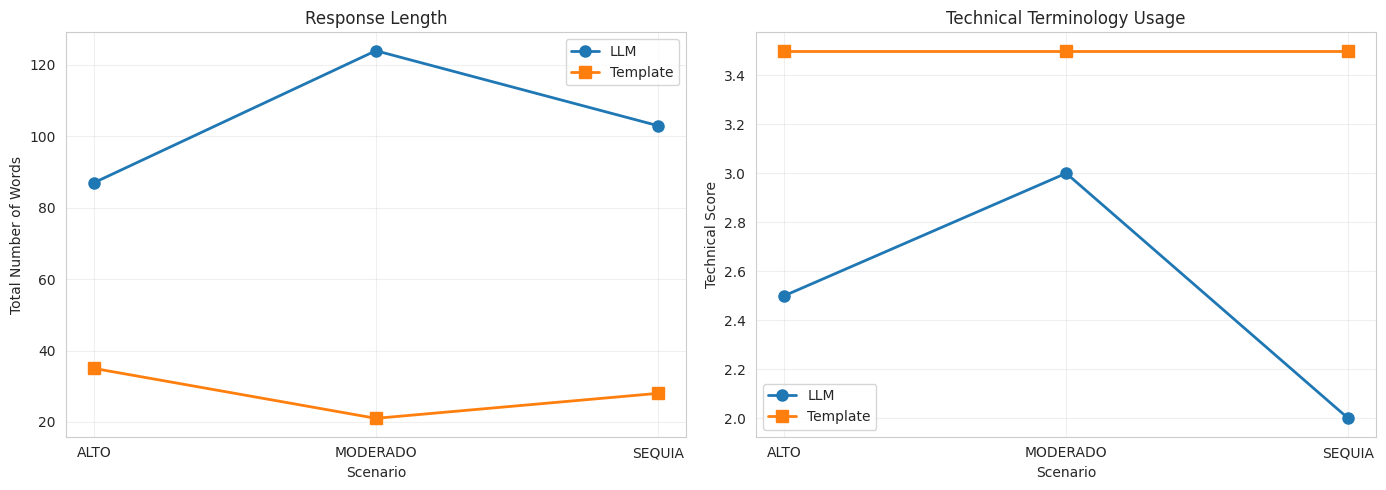

In [72]:
def generate_basic_recommendation(scenario: Dict) -> Dict:
    """Generate recommendation using basic templates (without LLM)."""
    risk = scenario['riesgo']
    percentage = scenario['porcentaje']
    forecast_level = scenario['nivel_predicho']
    max_level = scenario['capacidad_maxima']
    horizon = scenario['horizonte']
    
    if risk == 'ALTO':
        reasoning = (f"Forecast level will reach {percentage:.1f}% of maximum capacity "
                    f"({max_level:.2f} hm³) in the next {horizon} days, with expected level of "
                    f"{forecast_level:.2f} hm³.")
        action = ("URGENT: Plan preventive discharges. Coordinate with basin authorities. "
                 "Activate emergency protocols and alert systems.")
    
    elif risk == 'MODERADO':
        reasoning = (f"Forecast level will reach {percentage:.1f}% of capacity "
                    f"({forecast_level:.2f} hm³) within {horizon} days.")
        action = ("Increase monitoring frequency. Evaluate gradual discharges. "
                 "Review weather forecasts.")
    
    elif risk == 'SEQUIA':
        reasoning = (f"Forecast level will drop to {percentage:.1f}% of capacity "
                    f"({forecast_level:.2f} hm³) in {horizon} days. Risk of water insufficiency.")
        action = ("CRITICAL: Activate scarcity protocols. Implement usage restrictions. "
                 "Evaluate alternative supply sources.")
    
    else:  # BAJO
        reasoning = (f"Forecast level will remain at {percentage:.1f}% of capacity "
                    f"({forecast_level:.2f} hm³), within optimal operational range.")
        action = ("Continue standard monitoring. Level stable and safe. "
                 "No special actions required.")
    
    return {
        'reasoning': reasoning,
        'recommended_action': action
    }

print("=" * 60)
print("COMPARISON: LLM vs BASIC TEMPLATES")
print("=" * 60)

comparisons = []

for scenario in test_scenarios:
    print(f"\nScenario: {scenario['riesgo']} ({scenario['porcentaje']:.1f}%)")
    
    # Generate with LLM
    llm_result, llm_time = generate_recommendation_ollama(scenario)
    
    # Generate with basic template
    basic_result = generate_basic_recommendation(scenario)
    
    if 'error' not in llm_result:
        print(f"\n   [LLM] ({llm_time:.0f}ms):")
        print(f"      Reasoning: {llm_result.get('reasoning', '')[:150]}...")
        print(f"      Action: {llm_result.get('recommended_action', '')[:150]}...")
        
        print(f"\n   [Template]:")
        print(f"      Reasoning: {basic_result['reasoning'][:150]}...")
        print(f"      Action: {basic_result['recommended_action'][:150]}...")
        
        # Comparative analysis
        llm_metrics = analyze_response_quality(llm_result)
        basic_metrics = analyze_response_quality(basic_result)
        
        comparisons.append({
            'Risk': scenario['riesgo'],
            'LLM Words': llm_metrics['words_reasoning'] + llm_metrics['words_action'],
            'Template Words': basic_metrics['words_reasoning'] + basic_metrics['words_action'],
            'LLM Technical': llm_metrics['technical_score'],
            'Template Technical': basic_metrics['technical_score'],
            'Time (ms)': llm_time
        })

if comparisons:
    print("\n" + "=" * 60)
    print("COMPARATIVE TABLE")
    print("=" * 60)
    df_comp = pd.DataFrame(comparisons)
    print(tabulate(df_comp, headers='keys', tablefmt='grid', showindex=False))
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Length comparison
    x = range(len(comparisons))
    axes[0].plot(x, [c['LLM Words'] for c in comparisons], 'o-', label='LLM', linewidth=2, markersize=8)
    axes[0].plot(x, [c['Template Words'] for c in comparisons], 's-', label='Template', linewidth=2, markersize=8)
    axes[0].set_xlabel('Scenario')
    axes[0].set_ylabel('Total Number of Words')
    axes[0].set_title('Response Length')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([c['Risk'] for c in comparisons])
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Technical score comparison
    axes[1].plot(x, [c['LLM Technical'] for c in comparisons], 'o-', label='LLM', linewidth=2, markersize=8)
    axes[1].plot(x, [c['Template Technical'] for c in comparisons], 's-', label='Template', linewidth=2, markersize=8)
    axes[1].set_xlabel('Scenario')
    axes[1].set_ylabel('Technical Score')
    axes[1].set_title('Technical Terminology Usage')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([c['Risk'] for c in comparisons])
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()